In [1]:
import sys
from pathlib import Path

# Add parent directory to path to import from src
sys.path.insert(0, str(Path().absolute().parent))

from micrograd.engine import Value
from micrograd.loss import mean_squared_loss
from micrograd.nn import Neuron, Layer, MLP
from micrograd.utils import draw_graph

import matplotlib.pyplot as plt
import numpy as np

In [2]:
def f(x):
    return 5*x**2 + 2*x + 14

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = list(map(f, xs))
# plt.plot(xs, ys)
# plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [4]:
h = 0.0001

a = 3
b = -5
c = 2.0
d1 = a*b + c

a += h
d2 = a*b + c

# (f(x + h) - f(x)) / h
d1, d2, (d2-d1)/h

(-13.0, -13.0005, -5.000000000006111)

In [2]:
def demo():
    h = 0.0001
    
    a = Value(2.0)   ; a.label = 'a'  ; a.grad = -3.5
    b = Value(10.0)  ; b.label = 'b'  ; b.grad = 2.0
    e = Value(4.5)   ; e.label = 'e'  ; e.grad = -6
    f = Value(-3.0)  ; f.label = 'f'  ; f.grad = 9
    c = e * f        ; c.label = 'c'  ; c.grad = 2.0
    d = b + c        ; d.label = 'd'  ; d.grad = 2.0
    L1 = a * d       ; L1.label = 'L' ; L1.grad = 1.0

    a = Value(2.0)   ; a.label = 'a'
    b = Value(10.0)  ; b.label = 'b'
    e = Value(4.5)   ; e.label = 'e'
    f = Value(-3.0)  ; f.label = 'f'
    c = e * f        ; c.label = 'c'
    d = b + c        ; d.label = 'd'
    L2 = a * d       ; L2.label = 'L'

    # print((L2.data-L1.data)/h)
    return L1

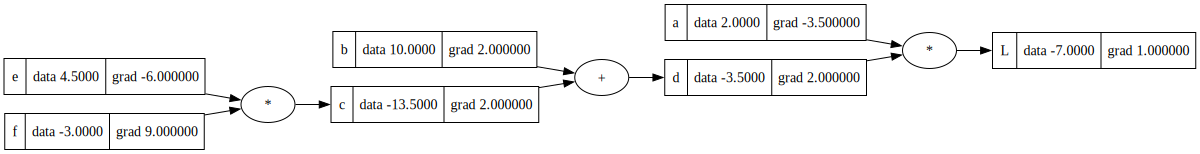

In [3]:
draw_graph(demo())

We have
`L = a * d`

We want to know
`dL/dd = ? a`

```
(f(d + h) - f(d)) / h
((d*f + h*f) - d*f) / h
h*f / h
f

Therefore the grad of L w.r.t d is just a
```

We have
`d = c + b`

We want to know
`dd/dc = ? b`

```
(f(x + h) - f(x)) / h
((c + h + b) - (c + b)) / h
h / h
1

Therefore the grad of d w.r.t c is just 1.0, and also 1.0 w.r.t b.
````

We know
`dL/dd and dd/dc`

Now we want to know
`dL/dc = ? d`

By the chain rule
`dL/dc = (dL / dd) * (dd / dc) = 2.0 * 1.0 = 2.0`
This is the same for `dL/db`. Where `dL/db = 2.0`
When use with the chain rule `dL/dd  * 1.0 = dL/dd`, so a plus node just routes the gradient from the parent to the children nodes.

Finally, we want to know `dL/df = ?` and `dL/de = ?`

First, get `dc/df` and `dc/de`
```
dc/df
(f(x + h) - f(x)) / h
((f*e + h*e) - f*e) / h
h*e / h
e = 4.5

dc/de
(f'(x + h) - f'(x)) / h
((f'*f + h*f) - f'*f) / h
h*f / h
f = -3.0
```

Now apply the chain rule
```
dL/df = (dL/dd) * (dd/dc) * (dc/df) = 2.0 * 1.0 * 4.5 = 9
dL/de = (dL/dd) * (dd/dc) * (dc/de) = 2.0 * 1.0 * -3.0 = -6.0
```

In [4]:
# inputs
x1 = Value(2.0)    ; x1.label = "x1"
x2 = Value(0.0)    ; x2.label = "x2"
# weights
w1 = Value(-3.0)   ; w1.label = "w1"
w2 = Value(1.0)    ; w2.label = "w2"
# bias
b = Value(6.8813735870195432)
b.label = 'b'

x1w1 = x1 * w1     ; x1w1.label = "x1w1"
x2w2 = x2 * w2     ; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b   ; n.label = 'n'

# tanh
e = (2*n).exp()
out = (e-1)/(e+1)

out.label = 'o'
out.backward()

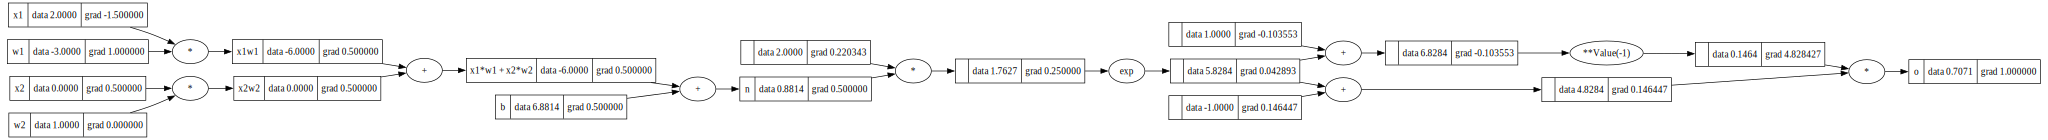

In [3]:
draw_graph(out)

In [9]:
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x1w1x2w2.grad = 0.5
# b.grad = 0.5

# do/dn = 1 - tanh**2(out)
# n.grad = 1 - out.data**2

In [5]:
# out._backward()
# n._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

In [2]:
x = [2.0, 3.0, 5.0]
n = MLP(3, [4,4,1])
n(x)

Value(0.942223500691809)

In [3]:
n = MLP(3, [4,4,1])
xs = [
    [2.0, 3.0, 5.0],
    [-4.0, 2.5, 2.0],
    [-1.0, 1.0, 3.0],
    [0.5, 3.5, 1.5],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets


# The smaller the loss, the closer the prediction is to the desired outputs
# So we want to minimise the loss
# This is the mean squared error loss
ypred = [n(x) for x in xs]
loss = sum((youts - ygt)**2 for ygt, youts in zip(ys, ypred))
loss

Value(6.9934075587257585)

In [4]:
# Train your NN!

learning_rate = 0.1
steps = 50

for k in range(steps):
    # 1. Forward pass
    ypred = [n(x) for x in xs]
    losses = mean_squared_loss(ys, ypred)
    data_loss = sum(losses) * (1.0 / len(losses))

    # 2. Backward pass
    # derive the gradient of each neuron
    for p in n.parameters():
        p.grad = 0.0
    data_loss.backward()

    # 3. Nudge
    # Gradient descent
    # nudging the data of each parameter in the direction of its gradient
    for p in n.parameters():
        p.data += -learning_rate * p.grad

    if not (k % 5):
        print(k, data_loss.data)

print(steps, data_loss.data)

0 1.7483518896814396
5 0.023349556842439178
10 0.01455368232786219
15 0.011227455596672816
20 0.009250888776864662
25 0.007893426248325728
30 0.0068905667376067455
35 0.006115176270443829
40 0.005496191674588737
45 0.004990012427719154
50 0.004646796593212544


In [5]:
ypred

[Value(0.9411142870790383),
 Value(-0.9315330387948606),
 Value(-0.9240292046161669),
 Value(0.931733077858146)]